对单个pickle文件读取检查轨迹是否正常

In [ ]:
import pickle 
# 假定一个元组
sample = 1
with open('/root/trajectory_prediction/icus_paper/highD_data/original_pickle_19_down/01.pickle', 'rb') as f:
    file = pickle.load(f)
print('- the file len is :',len(file))
print('- a traj len is :',len(file[sample][0]))
print('- the traj is : ',file[sample])
print('- the traj behavior is : ',file[sample][1])
print(file[0][0][0]['x'])
# 绘制该条轨迹
x = []
y = []
for i in range(len(file[sample][0])):
    x_temp = file[sample][0][i]['x']
    y_temp = file[sample][0][i]['y']
    x.append(x_temp)
    y.append(y_temp)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.legend()
plt.show()

统计左右转与直行的轨迹数目


In [ ]:
import os
import pickle

# define a dict to count the number of driving behavior
behavior_counts = {0:0 , 1:0, 2:0}
# 统计三类驾驶行为对应的轨迹序列长度大于等于200的有多少
seqlen_counts = {0:0, 1:0, 2:0}
directory_path ='/root/trajectory_prediction/icus_paper/highD_data/original_pickle_19_down'
for file in os.listdir(directory_path):
    if file.endswith(".pickle"):
        file_path = os.path.join(directory_path, file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            for item in data:
                behavior = item[1]
                seq_len = len(item[0])
                if behavior in behavior_counts:
                    behavior_counts[behavior] += 1
                    if seq_len >= 200:
                        seqlen_counts[behavior] += 1

# 打印每种行为的数量
print("直行数量:", behavior_counts[0])
print("左转数量:", behavior_counts[1])
print("右转数量:", behavior_counts[2])

# 打印每种行为轨迹序列长度大于等于200的数量
print('- straight : ',seqlen_counts[0])
print('- turn left : ',seqlen_counts[1])
print('- turn right : ',seqlen_counts[2])


分别将三类轨迹提取出来保存到对应的pickle中

平衡三类驾驶行为轨迹数量

In [ ]:
import os
import pickle 
import random
behavior_counts = {0:0 , 1:0, 2:0}
all_data = {0:[],1:[],2:[]} # 初始化一个字典来存储原始的所有数据
directory_path ='/root/trajectory_prediction/icus_paper/highD_data/original_pickle_19_down'
for file in os.listdir(directory_path):
    if file.endswith(".pickle"):
        file_path = os.path.join(directory_path, file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            for item in data:
                behavior = item[1]
                all_data[behavior].append(item)
                if behavior in behavior_counts:
                    behavior_counts[behavior] += 1
                    
# min_count = min(behavior_counts.values())
target_count = behavior_counts[1] # 已知左转数量最少，所以以其为基准
sampled_data = {0:[],1:[],2:[]} # 初始化一个字典来存储采样后的数据

# 对直行和右转轨迹采样
for behavior in [0,2]:
    while len(sampled_data[0 if behavior == 0 else 2]) < target_count and all_data[behavior]:
        sample_size = min(len(all_data[behavior]),target_count - len(sampled_data[0 if behavior == 0 else 2]))
        sampled_data[0 if behavior == 0 else 2].extend(random.sample(all_data[behavior],sample_size))
        all_data[behavior] = [item for item in all_data[behavior] if item not in sampled_data[0 if behavior == 0 else 2]]

# 直接将左转轨迹添加到sampled_data中
sampled_data[1] = all_data[1]

# 输出当前的三类轨迹数目
print("直行数量:", sampled_data[0])
print("左转数量:", sampled_data[1])
print("右转数量:", sampled_data[2])
# 将所有的轨迹都保存到一个pickle文件中
output_file = '/root/trajectory_prediction/icus_paper/highD_data/total_traj.pickle'
with open(output_file, 'wb') as f:
    pickle.dump(sampled_data, f)

print('- finish the sampling , the ouput file has been saved')


使用滑动窗口法来平衡三类轨迹数量

In [ ]:
# 目的是让滑动完后的三类轨迹数目一样就行
# 1、对左转的进行滑动窗口法，因为它最少，所以先对它进行处理
import os
import pickle

behavior_files = {0: 'straight.pickle', 1: 'turn_left.pickle', 2: 'turn_right.pickle'}

# 初始化存储每种行为轨迹的列表
trajectories_by_behavior = {k: [] for k in behavior_files.keys()}

directory_path = '/root/trajectory_prediction/icus_paper/highD_data/processed_data'

for file in os.listdir(directory_path):
    if file.endswith(".pickle"):
        file_path = os.path.join(directory_path, file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            for item in data:
                behavior = item[1]
                trajectory = item[0]
                # 将轨迹添加到对应的行为列表中
                trajectories_by_behavior[behavior].append(trajectory)
                
# 分别保存不同行为的轨迹到pickle文件
save_directory = '/root/trajectory_prediction/icus_paper/highD_data/behavior_pickle'
for behavior, filename in behavior_files.items():
    output_path = os.path.join(save_directory, filename)
    with open(output_path, 'wb') as f:
        pickle.dump(trajectories_by_behavior[behavior], f)
    print(f"{filename} saved successfully with {len(trajectories_by_behavior[behavior])} trajectories.")

测试单个pickle数据转为np (行x特征列数)的数据格式

In [ ]:
import pickle
import numpy as np
import os 
import matplotlib.pyplot as plt

# 单独测试一个pickle
traj_data = []
file_path = '/root/trajectory_prediction/icus_paper/highD_data/original_pickle_19_down/05.pickle'
# file_path = '/root/trajectory_prediction/icus_paper/highD_data/processed_data/05.pickle'
# file_path = '/root/trajectory_prediction/icus_paper/highD_data/total_traj.pickle'
with open(file_path, 'rb') as f:
    data = pickle.load(f)
    for i in range(len(data)):
        item = data[i]
        traj_data_temp = [value for sublist in item[0] for value in sublist.values()]
        traj_data.append(traj_data_temp)
print('- traj_data length : ',len(traj_data))
print(len(traj_data[0]))
print(traj_data[0])

num_sublists = len(traj_data[0]) // 19 # 目前是用的67个特征
# 将原始列表按19分割为若干子列表进行堆叠
sublists = [traj_data[0][i*19:(i+1)*19] for i in range(num_sublists)]

sublists = np.array(sublists)
stacked_list = np.vstack(sublists)

print('- stacked_list shape : ',stacked_list.shape)
x = stacked_list[:,0]
y = stacked_list[:,1]
plt.plot(x,y)
plt.show()

# 随便在id中选一个绘图,要按对应的特征维数来划分，原来19，现在67
num_sublists_2 = len(traj_data[18]) // 19
sublists_2 = [traj_data[18][i*19:(i+1)*19] for i in range(num_sublists_2)]
sublists_2 = np.array(sublists_2)
stacked_list_2 = np.vstack(sublists_2)

print('- stacked_list_2 shape : ',stacked_list_2.shape)
x2 = stacked_list_2[:,0]
y2 = stacked_list_2[:,1]
plt.plot(x2,y2)
plt.show()
    

同时对所有pickle文件的数据读取并转换数据组织格式，最后保存为npy

In [ ]:
# 同时完成所有pickle处理
import os
import numpy as np
import pickle
traj_data = []
# 现在用的是67维度 240629
directory_path ='/root/trajectory_prediction/icus_paper/highD_data/original_pickle_19_down'
save_npy_count = 0 # 保存文件的计数器
all_traj_count = 0 # 所有轨迹的计数器
for file in os.listdir(directory_path):
    if file.endswith(".pickle"):
        file_path = os.path.join(directory_path, file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            for i in range(len(data)):
                print('- now data length is :',len(data))
                item = data[i]
                traj_data_temp = [value for sublist in item[0] for value in sublist.values()]
                print('- traj_data_temp length is : ',len(traj_data_temp))
                traj_data.append(traj_data_temp)
                # traj_data里现在有多个子列表，每个子列表代表是一个车id
                num_sublists = len(traj_data_temp) // 19 # 每个子列表的长度不一定一样
                print('- now num_sublists length is :',num_sublists )
                # 将原始列表按19分割为若干子列表进行堆叠
                sublists = [traj_data_temp[k*19:(k+1)*19] for k in range(num_sublists)]
                sublists = np.array(sublists)
                stacked_list = np.vstack(sublists)
                print('- stacked_list shape is : ',stacked_list.shape)
                all_traj_count += 1
                print('- now processing the num is : ',all_traj_count)
                # 去除序列长度小于200的，只保留序列长度大于等于200的，并将其保存到npy中
                if stacked_list.shape[0] >= 200:
                    # filename = f'/root/trajectory_prediction/icus_paper/highD_data/original_npy/{save_npy_count}.npy'
                    filename = f'/root/trajectory_prediction/icus_paper/highD_data/original_npy_19_down/{save_npy_count}.npy'
                    np.save(filename, stacked_list)
                    save_npy_count += 1
                    print('- now save_npy_count is : ',save_npy_count)


In [ ]:
# 读取保存的一个npy文件，查看是否正常
import numpy as np
import matplotlib.pyplot as plt 
# file_path = '/root/trajectory_prediction/icus_paper/highD_data/original_npy/3990.npy'
file_path = '/root/trajectory_prediction/icus_paper/highD_data/original_npy_19_down/234.npy'

# file_path = '/root/trajectory_prediction/icus_paper/highD_data/only_first_pick_npy/1.npy'
data = np.load(file_path)
print(len(data))

x = data[:,0]
y = data[:,1]
# 限定y轴区间，使图像更直观
lower_limit = 0
upper_limit = 30
plt.ylim(lower_limit,upper_limit)
plt.plot(x,y)
plt.show()

将保存的npy文件中的不等长序列统一处理成长度为200（8s）的序列

In [ ]:
import os 
import numpy as np
save_npy_count = 0
# directory_path = '/root/trajectory_prediction/icus_paper/highD_data/original_npy'
directory_path = '/root/trajectory_prediction/icus_paper/highD_data/original_npy_19_down'
for filename in os.listdir(directory_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(directory_path, filename)
        trajectory = np.load(file_path)
        
        trimmed_trajectory = trajectory[:200] if trajectory.shape[0] >= 200 else trajectory
        filename = f'/root/trajectory_prediction/icus_paper/highD_data/seqlen200_19_down/{save_npy_count}.npy'
        np.save(filename, trimmed_trajectory)
        save_npy_count += 1
        print('- now save_npy_count is : ',save_npy_count)

滑窗处理成200序列长度

In [ ]:
import os 
import numpy as np
save_npy_count = 0
directory_path = '/root/trajectory_prediction/icus_paper/highD_data/original_npy_19_down'
# directory_path = '/root/trajectory_prediction/icus_paper/highD_data/motion_info_67_original_npy'
for filename in os.listdir(directory_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(directory_path, filename)
        trajectory = np.load(file_path)
        
        num_windows = (len(trajectory) - 200) // 10 + 1 # 步长为10
        slide_count = 0
        for i in range(0,num_windows*10,10):
            window = trajectory[i:i+200]
            filename = f'/root/trajectory_prediction/icus_paper/highD_data/slided_data_down/{save_npy_count}.npy'
            np.save(filename,window)
            save_npy_count += 1
            slide_count += 1 
            print('- now save_npy_count is : ',save_npy_count)
            # 一条轨迹最多划出5个窗口
            if slide_count == 15:
                break

            

        
    

为了适应TD-NAST的输入格式，需要扩展shape为(seq_len,num_obj,input_dim)

In [1]:
# 将已经滑动过的序列进行维度扩展，其中num_obj = 8,代表每条轨迹对应场景中考虑自车的8方位信息
import os 
import numpy as np
save_npy_count = 0
# directory_path = '/root/trajectory_prediction/icus_paper/highD_data/original_npy'
directory_path = '/root/trajectory_prediction/icus_paper/highD_data/slided_data_down'
for filename in os.listdir(directory_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(directory_path, filename)
        data = np.load(file_path)
        num_obj = 8
        expanded_data = np.repeat(np.expand_dims(data,axis=1),num_obj,axis=1)
        filename = f'/root/trajectory_prediction/TD-NAST/highd_data/expanded_data/{save_npy_count}.npy'
        np.save(filename, expanded_data)
        save_npy_count += 1
        print('- now save_npy_count is : ',save_npy_count)
        
        

- now save_npy_count is :  1
- now save_npy_count is :  2
- now save_npy_count is :  3
- now save_npy_count is :  4
- now save_npy_count is :  5
- now save_npy_count is :  6
- now save_npy_count is :  7
- now save_npy_count is :  8
- now save_npy_count is :  9
- now save_npy_count is :  10
- now save_npy_count is :  11
- now save_npy_count is :  12
- now save_npy_count is :  13
- now save_npy_count is :  14
- now save_npy_count is :  15
- now save_npy_count is :  16
- now save_npy_count is :  17
- now save_npy_count is :  18
- now save_npy_count is :  19
- now save_npy_count is :  20
- now save_npy_count is :  21
- now save_npy_count is :  22
- now save_npy_count is :  23
- now save_npy_count is :  24
- now save_npy_count is :  25
- now save_npy_count is :  26
- now save_npy_count is :  27
- now save_npy_count is :  28
- now save_npy_count is :  29
- now save_npy_count is :  30
- now save_npy_count is :  31
- now save_npy_count is :  32
- now save_npy_count is :  33
- now save_npy_coun

检查序列长度为200的轨迹npy文件是否正常

In [2]:
# 读取保存的一个npy文件，查看是否正常
import numpy as np
import matplotlib.pyplot as plt 
# file_path = '/root/trajectory_prediction/icus_paper/highD_data/seqlen200_npy/1221.npy'
# file_path = '/root/trajectory_prediction/icus_paper/highD_data/motion_info_67_seqlen200_npy/1221.npy'
file_path = '/root/trajectory_prediction/TD-NAST/highd_data/expanded_data/170.npy'
data = np.load(file_path)
print(data.shape)

# x = data[:,0]
# y = data[:,1]
# # 限定y轴区间，使图像更直观
# lower_limit = 0
# upper_limit = 40
# plt.ylim(lower_limit,upper_limit)
# plt.plot(x,y)
# plt.show()

(200, 8, 19)


将序列处理成训练集和验证集，训练集每个轨迹点仅包含1前7个特征，即含x,y,vx,vy,ax,ay,type

In [1]:
import os
import numpy as np

# directory_path = '/root/trajectory_prediction/icus_paper/highD_data/seqlen200_npy'
# directory_path = '/root/trajectory_prediction/icus_paper/highD_data/motion_info_67_seqlen200_npy'
# directory_path = '/root/trajectory_prediction/icus_paper/highD_data/seqlen200_19_down'
directory_path = '/root/trajectory_prediction/TD-NAST/highd_data/expanded_data'
total_files = len([name for name in os.listdir(directory_path) if name.endswith('.npy')])
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2
train_size = int(total_files * train_ratio)
val_size = int(total_files * val_ratio)
test_size = total_files - train_size - val_size

# 读取、合并npy
def merge_npy_files(file_list):
    return np.concatenate([np.load(os.path.join(directory_path, file_name))[None,...] for file_name in file_list],axis=0)

# 获取所有npy文件名并随机打乱顺序
file_names = np.random.permutation([name for name in os.listdir(directory_path) if name.endswith('.npy')])

# 划分训练集、验证集、测试集
train_files = file_names[:train_size]
val_files = file_names[train_size:train_size+val_size]
test_files = file_names[train_size+val_size:]

# 合并数据集
train_data = merge_npy_files(train_files)
val_data = merge_npy_files(val_files)
test_data = merge_npy_files(test_files)

print('- train_data shape is : ',train_data.shape)
print('- valid_data shape is : ',val_data.shape)
print('- test_data shape is : ',test_data.shape)

# 分离数据和标签，标签仅含x,y,vx,vy,ax,ay,type坐标，我的数据中xy是在index=0和1
train_data = train_data[:, :,:, :7]
val_data = val_data[:, :,:, :7]
test_data = test_data[:, :,:, :7]

# 保存数据集和标签
save_directory = '/root/trajectory_prediction/TD-NAST/highd_data/final_merge_data'
np.save(save_directory + '/train_data.npy', train_data)
np.save(save_directory + '/val_data.npy', val_data)
np.save(save_directory + '/test_data.npy', test_data)


print('- data has been split and saved !')

- train_data shape is :  (8667, 200, 8, 19)
- valid_data shape is :  (2889, 200, 8, 19)
- test_data shape is :  (2889, 200, 8, 19)
- data has been split and saved !


检查合并后的数据集轨迹是否正常

(38622, 200, 19)


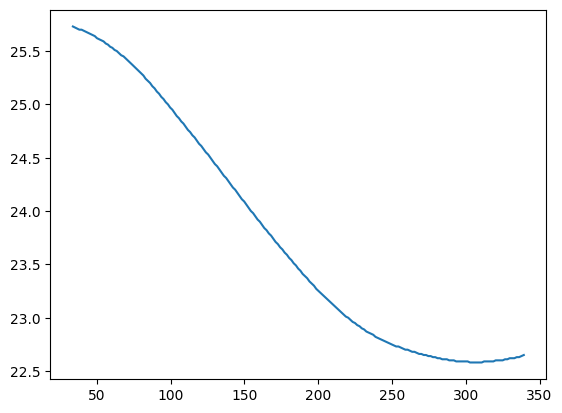

In [4]:
# 读取保存的一个npy文件，查看是否正常
import numpy as np
import matplotlib.pyplot as plt 
# file_path = '/root/trajectory_prediction/icus_paper/highD_data/final_merge_data/val_data.npy'
file_path = '/root/trajectory_prediction/icus_paper/highD_data/final_merge_data_slide_down/train_data.npy'
# file_path = '/root/trajectory_prediction/icus_paper/highD_data/final_merge_data/test_data.npy'
data = np.load(file_path)
print(data.shape)

x = data[112,:,0]
y = data[112,:,1]
# 限定y轴区间，使图像更直观
lower_limit = 0
upper_limit = 40
# plt.ylim(lower_limit,upper_limit)
plt.plot(x,y)
plt.show()

In [ ]:
# 读取保存的一个npy文件，查看是否正常
import numpy as np
import matplotlib.pyplot as plt 
# file_path_y = '/root/trajectory_prediction/mtf-lstm/NGSIM/y_test_0.npy'
# data_y = np.load(file_path)
# print(data_y.shape)

# y存储的是序列的驾驶行为啊

file_path_x = '/root/trajectory_prediction/mtf-lstm/NGSIM/X_valid_0.npy'
data_x = np.load(file_path_x)
print('- ngsim data_x_test is : \n',data_x.shape)

# 绘制NGSIM的车辆坐标图
x_coord = data_x[111,:,0]
y_coord = data_x[111,:,1]
plt.plot(y_coord,x_coord)
plt.show()
